<h1><strong>Финальная работа. Часть4. Основная модель с преобразованными данными методом расчета экспоненциально взвешенного скользящего среднего (EWMA). Применение метода undersampling на аналогичной выборки для сравнения с основной моделью</strong></h1>


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Для работы с несбалансируемой выборкой
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.under_sampling import InstanceHardnessThreshold


In [ ]:
import warnings
warnings.filterwarnings('ignore')

Загрузим сохраненные преобразованные данные из 2 части после расчета  экспоненциально взвешенного скользящего среднего для выбранных по важности признаков

In [ ]:
train_0 = pd.read_csv('/Users/irinaryzova/Desktop/skillbox/ML Junior/Финальная работа/Файлы для модели/train_0.csv')
train_1 = pd.read_csv('/Users/irinaryzova/Desktop/skillbox/ML Junior/Финальная работа/Файлы для модели/train_1.csv')
train_2 = pd.read_csv('/Users/irinaryzova/Desktop/skillbox/ML Junior/Финальная работа/Файлы для модели/train_2.csv')
train_3 = pd.read_csv('/Users/irinaryzova/Desktop/skillbox/ML Junior/Финальная работа/Файлы для модели/train_3.csv')
train_4 = pd.read_csv('/Users/irinaryzova/Desktop/skillbox/ML Junior/Финальная работа/Файлы для модели/train_4.csv')
train_6 = pd.read_csv('/Users/irinaryzova/Desktop/skillbox/ML Junior/Финальная работа/Файлы для модели/train_6.csv')

In [ ]:
train = pd.concat([train_0, train_1, train_2, train_3, train_4, train_6], sort=False, axis=0)

In [ ]:
del train_0, train_1, train_2, train_3, train_4, train_6

In [ ]:
train = train.fillna(0)

In [ ]:
target = pd.read_csv("/Users/irinaryzova/Desktop/skillbox/ML Junior/Финальная работа/Файлы для модели/train_target.csv")

In [ ]:
data = train.merge(target, on=["id"])
data

,id,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,pre_util_0,pre_util_1,pre_util_2,...,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,history_lenght,pre_loans530_19,enc_loans_credit_type_6,enc_loans_credit_type_7,flag
0,0,0.000000,0.072727,0.0,0.163636,0.763636,0.000000,0.000000,0.163636,0.000000,...,0.163636,0.127273,0.000000,0.272727,0.000000,10,0.0,0.0,0.0,0
1,1,0.000000,0.219048,0.0,0.352381,0.428571,0.000000,0.019048,0.000000,0.009524,...,0.257143,0.000000,0.123810,0.104762,0.114286,14,0.0,0.0,0.0,0
2,2,0.000000,0.000000,0.0,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.666667,0.000000,0.000000,0.000000,0.000000,3,0.0,0.0,0.0,0
3,3,0.000000,0.100000,0.0,0.266667,0.516667,0.116667,0.000000,0.000000,0.066667,...,0.441667,0.041667,0.000000,0.000000,0.000000,15,0.0,0.0,0.0,0
4,4,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499995,1749995,0.000000,0.000000,0.0,0.340659,0.659341,0.000000,0.000000,0.000000,0.000000,...,0.307692,0.000000,0.065934,0.098901,0.000000,13,0.0,0.0,0.0,0
1499996,1749996,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0
1499997,1749997,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0
1499998,1749998,0.045455,0.212121,0.0,0.378788,0.363636,0.000000,0.166667,0.000000,0.000000,...,0.848485,0.000000,0.000000,0.000000,0.000000,11,0.0,0.0,0.0,0


In [ ]:
del train

In [ ]:
df_train = data.iloc[:1250000]  # Первые 1250000 строк
df_test = data.iloc[1250000:1250000+500000]  # Следующие 500000 строк

In [ ]:
df_train

,id,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,pre_util_0,pre_util_1,pre_util_2,...,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,history_lenght,pre_loans530_19,enc_loans_credit_type_6,enc_loans_credit_type_7,flag
0,0,0.000000,0.072727,0.0,0.163636,0.763636,0.000000,0.000000,0.163636,0.000000,...,0.163636,0.127273,0.000000,0.272727,0.000000,10,0.0,0.0,0.0,0
1,1,0.000000,0.219048,0.0,0.352381,0.428571,0.000000,0.019048,0.000000,0.009524,...,0.257143,0.000000,0.123810,0.104762,0.114286,14,0.0,0.0,0.0,0
2,2,0.000000,0.000000,0.0,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.666667,0.000000,0.000000,0.000000,0.000000,3,0.0,0.0,0.0,0
3,3,0.000000,0.100000,0.0,0.266667,0.516667,0.116667,0.000000,0.000000,0.066667,...,0.441667,0.041667,0.000000,0.000000,0.000000,15,0.0,0.0,0.0,0
4,4,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249995,1249995,0.000000,0.000000,0.0,0.197802,0.802198,0.000000,0.000000,0.000000,0.000000,...,0.131868,0.000000,0.054945,0.000000,0.000000,13,0.0,0.0,0.0,0
1249996,1249996,0.104575,0.169935,0.0,0.228758,0.496732,0.000000,0.000000,0.104575,0.000000,...,0.418301,0.000000,0.000000,0.000000,0.078431,17,0.0,0.0,0.0,0
1249997,1249997,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0
1249998,1249998,0.000000,0.000000,0.0,0.533333,0.466667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.133333,0.000000,0.000000,5,0.0,0.0,0.0,0


In [ ]:
df_test

,id,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,pre_util_0,pre_util_1,pre_util_2,...,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,history_lenght,pre_loans530_19,enc_loans_credit_type_6,enc_loans_credit_type_7,flag
1250000,1500000,0.000000,0.000000,0.0,0.216374,0.783626,0.000000,0.000000,0.00000,0.105263,...,0.315789,0.081871,0.000000,0.000000,0.000000,18,0.0,0.0,0.0,0
1250001,1500001,0.000000,0.000000,0.0,0.333333,0.666667,0.000000,0.000000,0.00000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,2,0.0,0.0,0.0,0
1250002,1500002,0.000000,0.000000,0.0,0.527778,0.333333,0.138889,0.000000,0.00000,0.000000,...,0.444444,0.000000,0.000000,0.027778,0.250000,8,0.0,0.0,0.0,1
1250003,1500003,0.000000,0.095238,0.0,0.123810,0.780952,0.000000,0.000000,0.12381,0.095238,...,0.352381,0.114286,0.000000,0.076190,0.257143,14,0.0,0.0,0.0,0
1250004,1500004,0.000000,0.000000,0.0,0.700000,0.300000,0.000000,0.000000,0.00000,0.000000,...,0.400000,0.000000,0.000000,0.000000,0.000000,4,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499995,1749995,0.000000,0.000000,0.0,0.340659,0.659341,0.000000,0.000000,0.00000,0.000000,...,0.307692,0.000000,0.065934,0.098901,0.000000,13,0.0,0.0,0.0,0
1499996,1749996,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0
1499997,1749997,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0
1499998,1749998,0.045455,0.212121,0.0,0.378788,0.363636,0.000000,0.166667,0.00000,0.000000,...,0.848485,0.000000,0.000000,0.000000,0.000000,11,0.0,0.0,0.0,0


In [ ]:
del data

In [ ]:
X = df_train.drop(['flag', 'id'], axis=1)

y = df_train['flag']

In [ ]:
del df_train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train.value_counts()

flag
0    964894
1     35106
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

flag
0    241093
1      8907
Name: count, dtype: int64

In [ ]:
del X, y

In [ ]:
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

In [ ]:
ratio

27.485159232040107

In [ ]:
# XGBClassifier
xgbc_model = XGBClassifier(eval_metric='auc', random_state=42, scale_pos_weight=ratio)
xgbc_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=False)

y_pred_xgbc = xgbc_model.predict_proba(X_test)[:,1]
roc_auc_xgbc = roc_auc_score(y_test, y_pred_xgbc)

print('xgbc ROC-AUC: ', roc_auc_xgbc)

xgbc ROC-AUC:  0.7563100998340586


In [ ]:
# LGBMClassifier
ligthgbmc_model = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42,
                                is_unbalance=True, force_row_wise=True, verbose=0)

ligthgbmc_model.fit(X_train, y_train, eval_set = [(X_test, y_test)],eval_metric='auc')

y_pred_lgbmc = ligthgbmc_model.predict_proba(X_test)[:,1]
roc_auc_lgbmc = roc_auc_score(y_test, y_pred_lgbmc)

print('lgbmc ROC-AUC: ', roc_auc_lgbmc)

lgbmc ROC-AUC:  0.7639449032233355


In [ ]:
# CatBoostClassifier
cbc_model = CatBoostClassifier(verbose=300,
                               loss_function='Logloss',
                               eval_metric='AUC',
                               early_stopping_rounds=300,
                               task_type="CPU",
                               iterations=7000,
                               learning_rate=0.01,
                               auto_class_weights = 'Balanced',
                               depth=5,
                               l2_leaf_reg= 1,
                               random_state=42)

cbc_model.fit(X_train, y_train, eval_set = [(X_test, y_test)])

y_pred_cbc = cbc_model.predict_proba(X_test)[:,1]
roc_auc_cbc = roc_auc_score(y_test, y_pred_cbc)

print('cbc ROC-AUC: ', roc_auc_cbc)

0:	test: 0.6806403	best: 0.6806403 (0)	total: 299ms	remaining: 34m 52s
300:	test: 0.7446760	best: 0.7446760 (300)	total: 1m 1s	remaining: 22m 44s
600:	test: 0.7531050	best: 0.7531050 (600)	total: 2m 1s	remaining: 21m 33s
900:	test: 0.7571751	best: 0.7571751 (900)	total: 3m 1s	remaining: 20m 31s
1200:	test: 0.7597609	best: 0.7597609 (1200)	total: 4m 3s	remaining: 19m 36s
1500:	test: 0.7621369	best: 0.7621369 (1500)	total: 5m 6s	remaining: 18m 41s
1800:	test: 0.7642254	best: 0.7642254 (1800)	total: 6m 9s	remaining: 17m 47s
2100:	test: 0.7657468	best: 0.7657468 (2100)	total: 7m 13s	remaining: 16m 51s
2400:	test: 0.7669234	best: 0.7669234 (2400)	total: 8m 18s	remaining: 15m 54s
2700:	test: 0.7678785	best: 0.7678785 (2700)	total: 9m 24s	remaining: 14m 59s
3000:	test: 0.7685771	best: 0.7685771 (3000)	total: 10m 34s	remaining: 14m 5s
3300:	test: 0.7692342	best: 0.7692381 (3298)	total: 11m 45s	remaining: 13m 10s
3600:	test: 0.7697424	best: 0.7697495 (3597)	total: 12m 56s	remaining: 12m 13s
390

In [ ]:
# Предсказание на тестовых данных
y_pred = cbc_model.predict(X_test)


# Расчёт метрик качества
print("Классификационный отчет:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Классификационный отчет:
               precision    recall  f1-score   support

           0       0.98      0.71      0.83    241093
           1       0.08      0.69      0.15      8907

    accuracy                           0.71    250000
   macro avg       0.53      0.70      0.49    250000
weighted avg       0.95      0.71      0.80    250000

Confusion Matrix:
 [[171402  69691]
 [  2754   6153]]


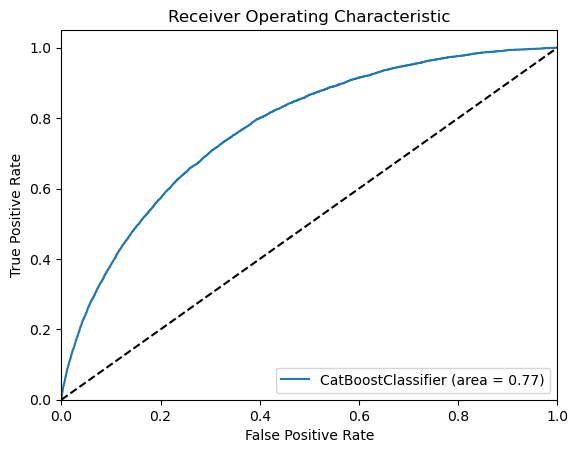

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, cbc_model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='CatBoostClassifier (area = %0.2f)' % roc_auc_cbc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Из трех моделей градиентного бустинга ROC-AUC больше всего у CatBoostClassifier. Выберим эту модель для подбора гиперпараметров и прогнозирование на отложенной выборки.**

In [ ]:
import optuna


def objective(trial):
    # Задаем диапазоны для гиперпараметров
    learning_rate = trial.suggest_float("learning_rate", 0.015, 0.025, step=0.001)
    depth = trial.suggest_int("depth", 5, 6, 7)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 0.5, 1.5, step=0.1)

    # Инициализация модели с параметрами от Optuna
    cbc_model = CatBoostClassifier(
        verbose=100,
        loss_function='Logloss',
        eval_metric='AUC',
        early_stopping_rounds=100,
        task_type="CPU",
        iterations=7000,
        learning_rate=learning_rate,
        auto_class_weights='Balanced',
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        random_state=42
    )

    # Обучение модели
    cbc_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    # Предсказания и оценка метрики
    y_pred_cbc = cbc_model.predict_proba(X_test)[:, 1]
    roc_auc_cbc = roc_auc_score(y_test, y_pred_cbc)a

    return roc_auc_cbc

# Создание и запуск оптимизации
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Печать результатов
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-15 22:20:26,516] A new study created in memory with name: no-name-ee80beb0-74b7-4c0e-884b-3ccb8183ebce
[I 2024-11-15 22:33:53,819] Trial 0 finished with value: 0.771543333118326 and parameters: {'learning_rate': 0.019, 'depth': 5, 'l2_leaf_reg': 1.0}. Best is trial 0 with value: 0.771543333118326.
[I 2024-11-15 22:46:07,332] Trial 1 finished with value: 0.7715039536848314 and parameters: {'learning_rate': 0.023, 'depth': 5, 'l2_leaf_reg': 0.9}. Best is trial 0 with value: 0.771543333118326.
[I 2024-11-15 23:03:36,858] Trial 2 finished with value: 0.771574532951171 and parameters: {'learning_rate': 0.016, 'depth': 5, 'l2_leaf_reg': 0.8}. Best is trial 2 with value: 0.771574532951171.
[I 2024-11-15 23:19:06,407] Trial 3 finished with value: 0.7716388539964386 and parameters: {'learning_rate': 0.017, 'depth': 5, 'l2_leaf_reg': 1.1}. Best is trial 3 with value: 0.7716388539964386.
[I 2024-11-15 23:33:45,673] Trial 4 finished with value: 0.7718128678404889 and parameters: {'learn

Best trial:
  Value: 0.7718128678404889
  Params: 
    learning_rate: 0.023
    depth: 5
    l2_leaf_reg: 1.2000000000000002


In [ ]:
cbc_model_best = CatBoostClassifier(verbose=300,
                               loss_function='Logloss',
                               eval_metric='AUC',
                               early_stopping_rounds=400,
                               task_type="CPU",
                               iterations=7000,
                               learning_rate=0.023,
                               auto_class_weights='Balanced',
                               depth=5,
                               l2_leaf_reg=1.2000000000000002,
                                random_state=42)

cbc_model_best.fit(X_train, y_train, eval_set = [(X_test,y_test)])

y_pred_best = cbc_model_best.predict_proba(X_test)[:,1]
roc_auc_best = roc_auc_score(y_test, y_pred_best)

print('cbc ROC-AUC: ', roc_auc_best)

0:	test: 0.6806403	best: 0.6806403 (0)	total: 219ms	remaining: 25m 34s
300:	test: 0.7548051	best: 0.7548051 (300)	total: 1m 3s	remaining: 23m 42s
600:	test: 0.7614370	best: 0.7614370 (600)	total: 2m 6s	remaining: 22m 26s
900:	test: 0.7656374	best: 0.7656380 (899)	total: 3m 11s	remaining: 21m 35s
1200:	test: 0.7680720	best: 0.7680760 (1199)	total: 4m 15s	remaining: 20m 35s
1500:	test: 0.7696368	best: 0.7696368 (1500)	total: 5m 19s	remaining: 19m 29s
1800:	test: 0.7705360	best: 0.7705360 (1800)	total: 6m 22s	remaining: 18m 24s
2100:	test: 0.7711537	best: 0.7711541 (2096)	total: 7m 29s	remaining: 17m 26s
2400:	test: 0.7714681	best: 0.7715033 (2357)	total: 8m 36s	remaining: 16m 30s
2700:	test: 0.7716764	best: 0.7717179 (2674)	total: 9m 45s	remaining: 15m 32s
3000:	test: 0.7717771	best: 0.7718129 (2957)	total: 10m 55s	remaining: 14m 33s
3300:	test: 0.7717904	best: 0.7718129 (2957)	total: 12m 4s	remaining: 13m 32s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.771812867

In [ ]:
# Предсказание на тестовых данных
y_pred_1 = cbc_model_best.predict(X_test)


# Расчёт метрик качества
print("Классификационный отчет:\n", classification_report(y_test, y_pred_1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_1))

Классификационный отчет:
               precision    recall  f1-score   support

           0       0.98      0.71      0.83    241093
           1       0.08      0.69      0.15      8907

    accuracy                           0.71    250000
   macro avg       0.53      0.70      0.49    250000
weighted avg       0.95      0.71      0.80    250000

Confusion Matrix:
 [[171489  69604]
 [  2757   6150]]


In [ ]:
print('Tree count: ' + str(cbc_model_best.tree_count_))

Tree count: 2958


**Дополнительный подбор гиперпараметров не улучшил качество модели, но снизилась величена iterations с 6813 до 2958  за счет увеличения learning_rate, что снижает время обучения модели. ROC-AUC на test = 0.7718**

Проведем Кросс валидацию

In [ ]:
from catboost import cv, Pool

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 3500
params['custom_loss'] = 'AUC'
params['random_state'] = 42
params['learning_rate'] = 0.023
params['early_stopping_rounds'] = 400
params['depth'] = 5
params['l2_leaf_reg'] = 1.2000000000000002
params['task_type'] = 'CPU'
params['auto_class_weights'] = 'Balanced'

cv_data = cv(
    params = params,
    pool = Pool(X, label=y),
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5773460394
bestIteration = 3036

Training on fold [1/5]

bestTest = 0.5733536323
bestIteration = 2809

Training on fold [2/5]

bestTest = 0.572488481
bestIteration = 2892

Training on fold [3/5]

bestTest = 0.5759180353
bestIteration = 2355

Training on fold [4/5]

bestTest = 0.5766313881
bestIteration = 2532



In [ ]:
cv_data

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.690381,0.000068,0.690357,0.000059,0.690730,0.002706
1,1,0.687725,0.000085,0.687691,0.000051,0.704381,0.003893
2,2,0.685132,0.000135,0.685083,0.000081,0.708586,0.003618
3,3,0.682645,0.000215,0.682599,0.000116,0.713976,0.003216
4,4,0.680184,0.000210,0.680140,0.000115,0.715443,0.003524
...,...,...,...,...,...,...,...
3432,3432,0.575267,0.002090,0.534810,0.003670,0.768822,0.002126
3433,3433,0.575267,0.002090,0.534807,0.003675,0.768822,0.002126
3434,3434,0.575268,0.002091,0.534805,0.003677,0.768822,0.002127
3435,3435,0.575268,0.002092,0.534803,0.003680,0.768821,0.002127


**ROC-AUC  по каждому fold [0.76655, 0.77064, 0.77156, 0.76802, 0.7676]. Среднее значение  ROC-AUC = 0.7689. Переобучения нет.**

Проверим модель на отложенной выборки.

In [ ]:
X_holdout_sample = df_test.drop(['flag', 'id'], axis=1)

y_holdout_sample = df_test['flag']

In [ ]:
ratio_test = float(y_holdout_sample.value_counts()[0]) / y_holdout_sample.value_counts()[1]

In [ ]:
ratio_test

24.974025974025974

In [ ]:
cbc_model_holdout = CatBoostClassifier(verbose=300,
                               loss_function='Logloss',
                               eval_metric='AUC',
                               early_stopping_rounds=400,
                               task_type="CPU",
                               iterations=7000,
                               learning_rate=0.023,
                               auto_class_weights='Balanced',
                               depth=5,
                               l2_leaf_reg=1.2000000000000002,
                                random_state=42)

cbc_model_holdout.fit(X_train, y_train, eval_set = [(X_holdout_sample,y_holdout_sample)])

y_pred_holdout = cbc_model_best.predict_proba(X_holdout_sample)[:,1]
roc_auc_holdout = roc_auc_score(y_holdout_sample, y_pred_holdout)

print('cbc ROC-AUC отложенные данные: ', roc_auc_holdout)

0:	test: 0.6583058	best: 0.6583058 (0)	total: 219ms	remaining: 25m 31s
300:	test: 0.7336204	best: 0.7336204 (300)	total: 1m 1s	remaining: 22m 47s
600:	test: 0.7400745	best: 0.7400745 (600)	total: 2m 2s	remaining: 21m 47s
900:	test: 0.7444676	best: 0.7444676 (900)	total: 3m 12s	remaining: 21m 41s
1200:	test: 0.7468667	best: 0.7468667 (1200)	total: 4m 24s	remaining: 21m 16s
1500:	test: 0.7482995	best: 0.7482995 (1500)	total: 5m 34s	remaining: 20m 27s
1800:	test: 0.7493683	best: 0.7493708 (1799)	total: 6m 45s	remaining: 19m 31s
2100:	test: 0.7500961	best: 0.7501055 (2095)	total: 7m 56s	remaining: 18m 30s
2400:	test: 0.7503700	best: 0.7504008 (2381)	total: 9m 6s	remaining: 17m 26s
2700:	test: 0.7505685	best: 0.7505685 (2700)	total: 10m 17s	remaining: 16m 22s
3000:	test: 0.7505346	best: 0.7506568 (2754)	total: 11m 29s	remaining: 15m 18s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7506567691
bestIteration = 2754

Shrink model to first 2755 iterations.
cbc ROC-AUC отл

**ROC-AUC на отложенных данных ниже чем на тестовых. Основная причина, разное соотношение классов целевой переменной у тестовой выборки (ratio=27.485) и отложенных данных (ratio_test=24.974). ROC-AUC на отложенных равен 0.7505, что выше заданного порога ROC-AUC=0.75. В качестве отложенной выборкм можно использовать любой из оставшихся первоначальных преобразованных данных.**

In [ ]:
# Предсказание на тестовых данных
y_pred_2 = cbc_model_holdout.predict(X_holdout_sample)


# Расчёт метрик качества
print("Классификационный отчет:\n", classification_report(y_holdout_sample, y_pred_2))
print("Confusion Matrix:\n", confusion_matrix(y_holdout_sample, y_pred_2))

Классификационный отчет:
               precision    recall  f1-score   support

           0       0.98      0.73      0.83    240375
           1       0.09      0.64      0.15      9625

    accuracy                           0.72    250000
   macro avg       0.53      0.68      0.49    250000
weighted avg       0.95      0.72      0.81    250000

Confusion Matrix:
 [[174365  66010]
 [  3442   6183]]


**Метод undersampling в бизнес-процессах, как правило, предпочтителен, когда:**

1. Ограничены ресурсы на сбор данных: Когда сбор дополнительных данных невозможен или ограничен (например, в медицинских исследованиях с ограниченным доступом к данным пациентов), undersampling помогает упростить обработку, уменьшив объем основной, часто избыточной, категории.

2. Реализация в реальном времени или на устройствах с ограниченными ресурсами: Для бизнес-процессов, в которых критично время, undersampling может снизить нагрузку на вычисления, что важно для быстрого анализа.

3. Отсутствие перекоса в показателях качества модели: Если бизнес-цель фокусируется на минимизации ложных положительных результатов, undersampling позволяет сфокусироваться на меньшем объеме данных с корректировкой модели без большого риска перекоса.

4. Необходимость интерпретируемости модели: Когда интерпретация модели важна для понимания редких событий (например, отток клиентов), undersampling снижает вероятность переобучения, что может улучшить прозрачность модели и повысить доверие со стороны бизнеса.

Таким образом, метод undersampling оправдан в ситуациях, когда необходимо оптимизировать производительность, экономить ресурсы, обеспечивать высокую интерпретируемость модели и при этом сохранять акцент на малочисленных, но значимых бизнес-событиях.

Используем модель undersampling - Instance Hardness Threshold

- Строит предсказание на основе модели классификации с использованием кросс-валидации (по умолчанию 5 фолдов).
- Оставляет правильно предсказанные объекты major-класса с наиболее высокими вероятностями предсказания.
- Могут использоваться различные модели классификации, по умолчанию применяется случайный лес.
  Применим модель HistGradientBoostingClassifier

В undersampling используем агрeгацию данных кридитов клиентов как среднеарифметическое с последующим округлением до целого значения.

В основной модели применили расчет экспоненциально взвешенного скользящего среднего (EWMA), что потребовало значителных объемов оперативной памяти.

Загрузим данные агрегированные по среднему в spark

In [ ]:
train_us = pd.read_csv("data_train_us.csv")
train_us

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,0,6.0,8.0,8.0,7.0,8.0,11.0,11.0,10.0,3.0,...,2.0,2.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
1,6,10.0,9.0,8.0,10.0,9.0,7.0,5.0,11.0,2.0,...,2.0,2.0,3.0,1.0,3.0,4.0,1.0,0.0,0.0,0
2,7,2.0,7.0,13.0,4.0,8.0,1.0,11.0,4.0,4.0,...,3.0,3.0,4.0,1.0,3.0,3.0,1.0,1.0,1.0,0
3,9,1.0,6.0,12.0,2.0,10.0,5.0,7.0,12.0,2.0,...,1.0,0.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
4,19,9.0,9.0,9.0,9.0,11.0,8.0,9.0,10.0,3.0,...,2.0,2.0,3.0,1.0,3.0,4.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249995,1249987,6.0,8.0,9.0,7.0,6.0,11.0,8.0,8.0,2.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
1249996,1249990,3.0,12.0,4.0,3.0,10.0,5.0,11.0,8.0,3.0,...,3.0,3.0,4.0,1.0,3.0,2.0,1.0,0.0,0.0,0
1249997,1249992,7.0,11.0,7.0,9.0,9.0,9.0,9.0,11.0,2.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0
1249998,1249993,1.0,3.0,9.0,4.0,9.0,1.0,14.0,8.0,3.0,...,3.0,3.0,4.0,1.0,3.0,3.0,1.0,1.0,0.0,0


In [ ]:
df_int8 = train_us.copy()
#Создаем список столбцов для преобразования, исключая 'id'
columns_to_convert = df_int8.columns.drop('id')

#Преобразуем выбранные столбцы в тип данных int8
df_int8[columns_to_convert] = df_int8[columns_to_convert].astype('int8')

In [ ]:
del train_us

In [ ]:
X_us = df_int8.drop(['flag', 'rn', 'id'], axis=1)

y_us = df_int8['flag']

In [ ]:
del df_int8

In [ ]:
y_us.value_counts()

flag
0    1205987
1      44013
Name: count, dtype: int64

In [ ]:
iht_hist = InstanceHardnessThreshold(
    estimator=HistGradientBoostingClassifier(random_state=42),
    sampling_strategy='auto',
    random_state=42,
    n_jobs=-1, cv=3)
hist_X, hist_y = iht_hist.fit_resample(X_us, y_us)

In [ ]:
hist_y.value_counts()

flag
0    44013
1    44013
Name: count, dtype: int64

In [ ]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(hist_X, hist_y, test_size=0.20396, random_state=42)

In [ ]:
y_train_us.value_counts()

flag
1    35106
0    34966
Name: count, dtype: int64

In [ ]:
y_test_us.value_counts()

flag
0    9047
1    8907
Name: count, dtype: int64

Соотношение количество класса "1" сопоставимо с данными основной модели(без undersampling) 35106 в train

In [ ]:
model_cat_us = CatBoostClassifier(random_state=42, eval_metric='F1',
                               iterations=200, custom_metric=['F1', 'AUC'], depth=4,
                                early_stopping_rounds=20)
model_cat_us.fit(X_train_us, y_train_us, verbose=0)

# 5. Предсказание на отложенных данных
y_pred_train_us = model_cat_us.predict(X_train_us)
y_pred_cat_us = model_cat_us.predict(X_test_us)

# 6. Расчёт метрик качества
print("Классификационный отчет train:\n", classification_report(y_train_us, y_pred_train_us))
print("Confusion Matrix train:\n", confusion_matrix(y_train_us, y_pred_train_us))
print("Классификационный отчет test:\n", classification_report(y_test_us, y_pred_cat_us))
print("Confusion Matrix test:\n", confusion_matrix(y_test_us, y_pred_cat_us))

# ROC AUC
roc_auc_train_us = roc_auc_score(y_train_us, model_cat_us.predict_proba(X_train_us)[:, 1])
roc_auc_test_us = roc_auc_score(y_test_us, model_cat_us.predict_proba(X_test_us)[:, 1])
print("ROC AUC train:", roc_auc_train_us)
print("ROC AUC test:", roc_auc_test_us)

print('Точность для обучающей выборки:', model_cat_us.score(X_train_us, y_train_us))
print('Точность для тестовой выборки:', model_cat_us.score(X_test_us, y_test_us))

Классификационный отчет train:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     34966
           1       1.00      0.98      0.99     35106

    accuracy                           0.99     70072
   macro avg       0.99      0.99      0.99     70072
weighted avg       0.99      0.99      0.99     70072

Confusion Matrix train:
 [[34948    18]
 [  663 34443]]
Классификационный отчет test:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9047
           1       1.00      0.98      0.99      8907

    accuracy                           0.99     17954
   macro avg       0.99      0.99      0.99     17954
weighted avg       0.99      0.99      0.99     17954

Confusion Matrix test:
 [[9032   15]
 [ 199 8708]]
ROC AUC train: 0.9979458799831786
ROC AUC test: 0.9957698919191619
Точность для обучающей выборки: 0.990281424820185
Точность для тестовой выборки: 0.9880806505514091


Кросс валидация

In [ ]:
from catboost import cv, Pool
train_pool = Pool(data=hist_X, label=hist_y)

In [ ]:
params = {
    'loss_function': 'Logloss',
    'iterations': 200,
    'depth': 4,
    'random_state': 42,
    'custom_metric': ['F1', 'AUC'],
    'eval_metric': 'F1'
}

In [ ]:
def print_cv_summary(cv_data_us):
    cv_data_us.head(10)

    best_value = cv_data_us['test-AUC-mean'].max()
    best_iter = cv_data_us['test-AUC-mean'].values.argmax()

    print('Best validation AUC score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data_us['test-AUC-std'][best_iter],
        best_iter)
    )

In [ ]:
cv_data_us = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    plot=False,
    stratified=True,
    verbose=False
)

print_cv_summary(cv_data_us)

Training on fold [0/5]

bestTest = 0.9775691184
bestIteration = 199

Training on fold [1/5]

bestTest = 0.9755559426
bestIteration = 196

Training on fold [2/5]

bestTest = 0.9771461717
bestIteration = 198

Training on fold [3/5]

bestTest = 0.976490393
bestIteration = 198

Training on fold [4/5]

bestTest = 0.9799317564
bestIteration = 196

Best validation AUC score : 0.9949±0.0005 on step 199


Переобучения нет

Применим undersampling к отложенным данным проведем  моделирование

In [ ]:
test_us = pd.read_csv("data_test_us.csv")
test_us

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,1500000,10.0,11.0,9.0,8.0,9.0,9.0,8.0,10.0,2.0,...,2.0,2.0,3.0,1.0,3.0,4.0,1.0,0.0,0.0,0
1,1500002,5.0,9.0,5.0,9.0,8.0,7.0,12.0,11.0,3.0,...,3.0,3.0,4.0,1.0,2.0,4.0,1.0,0.0,0.0,1
2,1500003,8.0,8.0,10.0,7.0,7.0,8.0,11.0,9.0,2.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
3,1500010,1.0,6.0,9.0,7.0,6.0,3.0,5.0,10.0,3.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
4,1500011,3.0,10.0,9.0,10.0,12.0,7.0,6.0,8.0,2.0,...,2.0,2.0,3.0,1.0,3.0,4.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,1749995,7.0,9.0,8.0,7.0,8.0,6.0,8.0,10.0,3.0,...,2.0,2.0,3.0,1.0,3.0,4.0,1.0,0.0,0.0,0
249996,1749996,1.0,6.0,16.0,0.0,8.0,8.0,11.0,8.0,2.0,...,0.0,0.0,1.0,1.0,2.0,3.0,1.0,0.0,1.0,0
249997,1749997,1.0,11.0,9.0,4.0,8.0,1.0,11.0,1.0,2.0,...,3.0,3.0,4.0,1.0,2.0,4.0,1.0,1.0,1.0,0
249998,1749998,6.0,7.0,6.0,5.0,9.0,8.0,9.0,12.0,2.0,...,2.0,2.0,3.0,2.0,2.0,3.0,1.0,0.0,0.0,0


In [ ]:
df_int8_holdout = test_us.copy()
#Создаем список столбцов для преобразования, исключая 'id'
columns_to_convert_holdout = df_int8_holdout.columns.drop('id')

#Преобразуем выбранные столбцы в тип данных int8
df_int8_holdout[columns_to_convert_holdout] = df_int8_holdout[columns_to_convert_holdout].astype('int8')

In [ ]:
del test_us

In [ ]:
X_holdout_us = df_int8_holdout.drop(['flag', 'rn', 'id'], axis=1)

y_holdout_us = df_int8_holdout['flag']

In [ ]:
del df_int8_holdout

In [ ]:
y_holdout_us.value_counts()

flag
0    240375
1      9625
Name: count, dtype: int64

In [ ]:
iht_hist_holdout = InstanceHardnessThreshold(
    estimator=HistGradientBoostingClassifier(random_state=42),
    sampling_strategy='auto',
    random_state=42,
    n_jobs=-1, cv=3)
hist_X_holdout, hist_y_holdout = iht_hist_holdout.fit_resample(X_holdout_us, y_holdout_us)

In [ ]:
hist_y_holdout.value_counts()

flag
0    9626
1    9625
Name: count, dtype: int64

In [ ]:
model_holdout_us = CatBoostClassifier(random_state=42, eval_metric='F1',
                               iterations=200, custom_metric=['F1', 'AUC'], depth=4,
                                early_stopping_rounds=20)
model_holdout_us.fit(X_train_us, y_train_us, verbose=0)

# 5. Предсказание на отложенных данных
y_pred_train_us = model_holdout_us.predict(X_train_us)
y_pred_cat_holdout = model_holdout_us.predict(hist_X_holdout)

# 6. Расчёт метрик качества
print("Классификационный отчет train:\n", classification_report(y_train_us, y_pred_train_us))
print("Confusion Matrix train:\n", confusion_matrix(y_train_us, y_pred_train_us))
print("Классификационный отчет holdout:\n", classification_report(hist_y_holdout, y_pred_cat_holdout))
print("Confusion Matrix holdout:\n", confusion_matrix(hist_y_holdout, y_pred_cat_holdout))

# ROC AUC
roc_auc_train_us = roc_auc_score(y_train_us, model_holdout_us.predict_proba(X_train_us)[:, 1])
roc_auc_holdout = roc_auc_score(hist_y_holdout, model_holdout_us.predict_proba(hist_X_holdout)[:, 1])
print("ROC AUC train:", roc_auc_train_us)
print("ROC AUC holdout:", roc_auc_holdout)

print('Точность для обучающей выборки:', model_holdout_us.score(X_train_us, y_train_us))
print('Точность для отложенной выборки:', model_holdout_us.score(hist_X_holdout, hist_y_holdout))

Классификационный отчет train:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     34966
           1       1.00      0.98      0.99     35106

    accuracy                           0.99     70072
   macro avg       0.99      0.99      0.99     70072
weighted avg       0.99      0.99      0.99     70072

Confusion Matrix train:
 [[34948    18]
 [  663 34443]]
Классификационный отчет holdout:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90      9626
           1       0.86      0.98      0.91      9625

    accuracy                           0.91     19251
   macro avg       0.91      0.91      0.91     19251
weighted avg       0.91      0.91      0.91     19251

Confusion Matrix holdout:
 [[8049 1577]
 [ 225 9400]]
ROC AUC train: 0.9979458799831786
ROC AUC holdout: 0.9871043359300163
Точность для обучающей выборки: 0.990281424820185
Точность для отложенной выборки: 0.906394473014388

**Выводы: Приимущества undersampling подтверждено при ограниченнии в вычеслительных рексурсах. Высокое значение ROC-AUC я не счетаю признаком переобучения.
Сам главное приимущества:**
**1. Модель InstanceHardnessThreshold (https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.InstanceHardnessThreshold.html) совместно с HistGradientBoostingClassifier(модель градиентного бустинга) очистила данные мажорного класса от значений имеющих низкую вероятность. Это подтвержденно тем, что в основной модели эти значения находятся в ложноположительных(FP) и ложноотрецательных значениях(FN). Данный метод позволил увеличить точность предсказания клиентов с дефолтом по кредиту. Ссылка на статью успешного применения метода undersampling с InstanceHardnessThreshold - https://jurnal.ugm.ac.id/ijitee/article/view/42152**